This script serves as a sanity check on the representation level.
The different data representations are used to classify call types as a proof of sufficient information.

DFA (PAFs), simple MLPs (LFCCs) and CNNs (spectrograms) are used to classify the different call types.

In [1]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
RANDOM_SEED = 42
random.seed(42)
np.random.seed(42)

In [3]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_lfccs'] = calls_df['log_padded_lfccs'].apply(lambda x: np.asarray(json.loads(x)))

In [4]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[calls_df['call_type'] != 'unknown']
calls_df.info()

811
<class 'pandas.core.frame.DataFrame'>
Index: 6323 entries, 0 to 7282
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                6323 non-null   object 
 1   clip_ID                 6323 non-null   object 
 2   goose_ID                6323 non-null   object 
 3   call_type               6323 non-null   object 
 4   waveform                6323 non-null   object 
 5   sr                      6323 non-null   int64  
 6   filepath                6323 non-null   object 
 7   lfccs                   6323 non-null   object 
 8   peak                    6323 non-null   float64
 9   duration                6323 non-null   float64
 10  log_padded_spectrogram  6323 non-null   object 
 11  log_padded_lfccs        6323 non-null   object 
 12  f0mean                  6323 non-null   float64
 13  f0range                 6323 non-null   float64
 14  f0min                   6323 non-null   f

In [5]:
le = LabelEncoder()
y = le.fit_transform(calls_df["call_type"])

## DFA

In [6]:
features_list = ["duration", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1"]

In [7]:
X = calls_df[features_list].values
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
qda = QDA(reg_param=0.2)
qda.fit(X_train, y_train)

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(reg_param=0.2)

In [9]:
y_pred = qda.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

       alarm       0.00      0.00      0.00        14
     contact       0.46      0.21      0.28       228
   departure       0.77      0.83      0.80       214
    distance       0.92      0.91      0.91        98
 recruitment       0.72      0.87      0.79       651
     triumph       0.26      0.12      0.16        60

    accuracy                           0.70      1265
   macro avg       0.52      0.49      0.49      1265
weighted avg       0.66      0.70      0.67      1265

Accuracy: 0.7027667984189724


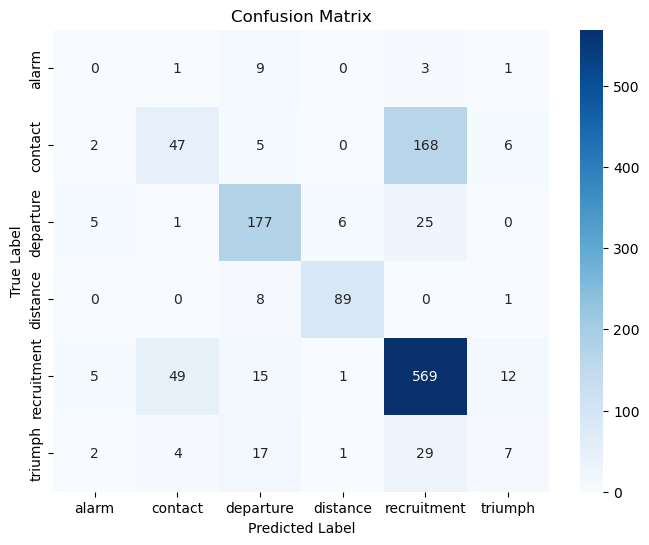

In [10]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [11]:
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, shrinkage=0, solver='lsqr')

              precision    recall  f1-score   support

       alarm       0.05      0.07      0.06        14
     contact       0.59      0.07      0.13       228
   departure       0.84      0.79      0.82       214
    distance       0.97      0.91      0.94        98
 recruitment       0.70      0.95      0.81       651
     triumph       0.31      0.22      0.25        60

    accuracy                           0.72      1265
   macro avg       0.58      0.50      0.50      1265
weighted avg       0.70      0.72      0.66      1265

Accuracy: 0.71699604743083
Feature coefficients per class:
   duration    f0mean   f0range     f0min     f0max  f0std_dev  mean_slope  \
0 -1.287448  9.308294  0.680101 -1.167731 -0.325774  -0.992151   -0.453475   
1 -0.888282  0.446316 -0.995798  0.216377 -0.623857   0.972619    0.351613   
2  1.502519 -1.138024  2.067075 -0.830374  1.013987  -2.066850   -0.682432   
3  3.836731 -5.979485  1.934937  0.949214  2.221850  -2.357568   -0.857550   
4 -0.826

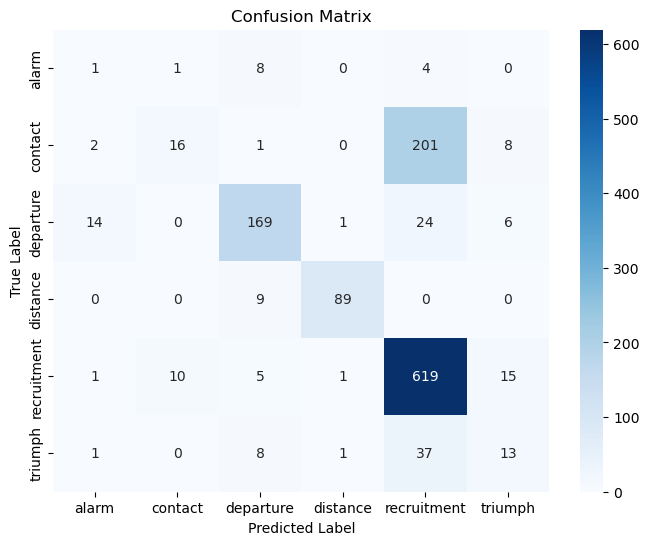

In [12]:
y_pred = lda.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))

coef_df = pd.DataFrame(lda.coef_, columns=features_list, index=lda.classes_)
print("Feature coefficients per class:")
print(coef_df)

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', 0.0, 0.1, 0.5, 1.0],
    'n_components': [1, 2, 3]
}

# GridSearchCV for LDA
grid_search = GridSearchCV(LDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'n_components': 1, 'shrinkage': 0.0, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.6789241270921055
Test Accuracy: 0.71699604743083


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
78 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

In [14]:
param_grid = {'reg_param': [0.0, 0.1, 0.2, 0.5, 1.0]}

# GridSearchCV for QDA
grid_search = GridSearchCV(QDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_qda = grid_search.best_estimator_
y_pred = best_qda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'reg_param': 0.2}
Best Cross-Validation Accuracy: 0.67832909145643
Test Accuracy: 0.7027667984189724


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/len

In [15]:
abs_coef = coef_df.abs().mean(axis=0)
print("Feature Importance Ranking:")
print(abs_coef.sort_values(ascending=False))

Feature Importance Ranking:
centr_t        4.366481
f0mean         2.953014
duration       1.702176
f0_q3          1.386038
f0std_dev      1.249784
f0range        1.080340
f0_q1          0.870566
f0_q2          0.844301
f0max          0.764888
std_s          0.714070
kurt_t         0.699711
skew_t         0.676554
centr_s        0.657893
skew_s         0.630122
f0min          0.592586
avg_f_form1    0.552402
mean_slope     0.470651
std_t          0.380654
hnr            0.334767
kurt_s         0.177408
dtype: float64


In [16]:
# simulate chance level
true_labels = calls_df["call_type"]
class_probs = true_labels.value_counts(normalize=True)
random_predictions = np.random.choice(class_probs.index, size=len(true_labels), p=class_probs.values)

# Calculate accuracy for random guessing
random_accuracy = accuracy_score(true_labels, random_predictions)

print("Empirical Chance Level (Random Guessing):", random_accuracy)


Empirical Chance Level (Random Guessing): 0.3098212873635932


In [17]:
# Permutation test to evaluate the significance of LDA model's accuracy
def permutation_test(X, y, model, num_permutations=20, test_size=0.2, random_state=RANDOM_SEED):

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Train LDA and calculate the accuracy
    model.fit(X_train, y_train)
    real_accuracy = accuracy_score(y_test, model.predict(X_test))

    # List to store accuracies from shuffled labels
    permuted_accuracies = []

    # Perform permutation test
    for _ in range(num_permutations):
        # Shuffle labels
        shuffled_y = np.random.permutation(y)

        # Train LDA on shuffled labels
        model.fit(X_train, shuffled_y[:len(y_train)])
        permuted_accuracy = accuracy_score(y_test, model.predict(X_test))

        # Append permuted accuracy to list
        permuted_accuracies.append(permuted_accuracy)

    # Calculate p-value
    permuted_accuracies = np.array(permuted_accuracies)
    p_value = np.mean(permuted_accuracies >= real_accuracy)


    # Plot histogram of permuted accuracies
    plt.hist(permuted_accuracies, alpha=0.7, color='blue', label='Permuted Accuracies')

    plt.axvline(real_accuracy, color='red', linestyle='dashed', linewidth=1, label='Real Accuracy')

    plt.title(f"Permutation Test for {str(model)}")
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    print("Real Accuracy:", real_accuracy)
    print("P-value:", "{:.8f}".format(p_value))

    return real_accuracy, permuted_accuracies, p_value

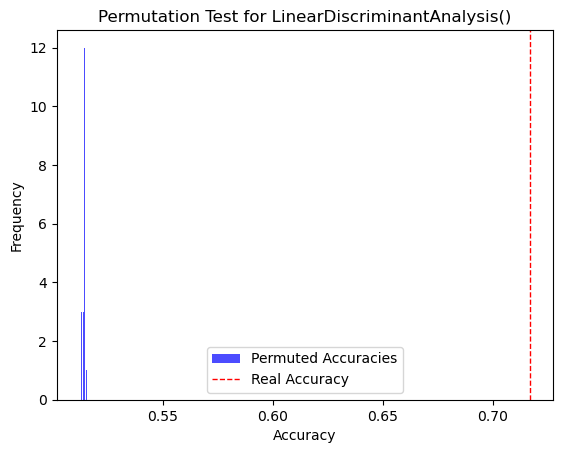

Real Accuracy: 0.71699604743083
P-value: 0.00000000


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/len

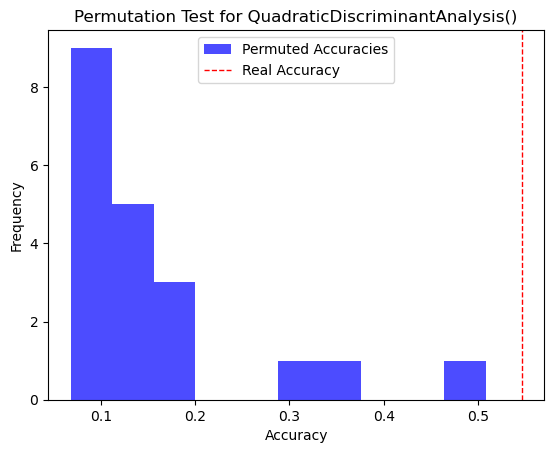

Real Accuracy: 0.5462450592885375
P-value: 0.00000000


In [18]:
real_accuracy, permuted_accuracies, p_value = permutation_test(X_scaled, y, LDA())
real_accuracy, permuted_accuracies, p_value = permutation_test(X_scaled, y, QDA())


## MLP

## CNN

#### LFCCs

In [19]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
N_EPOCHS = 100

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [21]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

In [22]:
class LFCCDataset(Dataset):
    def __init__(self, df):
        self.features = np.array(df['log_padded_lfccs'].tolist(), dtype=np.float32)  # Shape: (n_samples, 16, 215)
        self.labels = np.array(df['encoded_call_type'], dtype=np.int64)  # Shape: (n_samples,)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        return torch.tensor(x), torch.tensor(y)

ds = LFCCDataset(calls_df)

num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = round(num_items * 0.1)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 16, 215])
16 215


In [24]:
class LFCCCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 16, 215)
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1), # (32, 16, 215)
            nn.MaxPool2d(kernel_size=(2, 2)), # (32, 8, 107)
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), # (64, 8, 107)
            nn.Flatten(),
            nn.Linear(64 * 8 * 107, 128),  # Flattened size: 64 * (16/2) * (215/2)
            nn.Linear(128, num_classes),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# Instantiate model
num_classes = 6
model = LFCCCNN(num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
model.to(device)

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dl):.4f}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/20, Loss: 59.6518
Epoch 2/20, Loss: 13.7652
Epoch 3/20, Loss: 7.5442
Epoch 4/20, Loss: 4.4937
Epoch 5/20, Loss: 3.3064
Epoch 6/20, Loss: 2.9136
Epoch 7/20, Loss: 2.6778
Epoch 8/20, Loss: 2.3237
Epoch 9/20, Loss: 2.5027
Epoch 10/20, Loss: 2.7510
Epoch 11/20, Loss: 2.1412
Epoch 12/20, Loss: 2.0011
Epoch 13/20, Loss: 1.9539
Epoch 14/20, Loss: 1.5783
Epoch 15/20, Loss: 1.3533
Epoch 16/20, Loss: 1.2517
Epoch 17/20, Loss: 1.3222
Epoch 18/20, Loss: 1.3656
Epoch 19/20, Loss: 1.2227
Epoch 20/20, Loss: 1.1298
Test Accuracy: 79.27%


In [25]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get the predicted class (index with max probability)
        _, predicted = torch.max(outputs, 1)
        
        # Append to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

              precision    recall  f1-score   support

       alarm       0.11      0.08      0.10        12
     contact       0.57      0.59      0.58       126
   departure       0.87      0.90      0.89       108
    distance       0.97      0.90      0.94        40
 recruitment       0.80      0.84      0.82       312
     triumph       0.55      0.31      0.40        35

    accuracy                           0.76       633
   macro avg       0.65      0.60      0.62       633
weighted avg       0.75      0.76      0.75       633



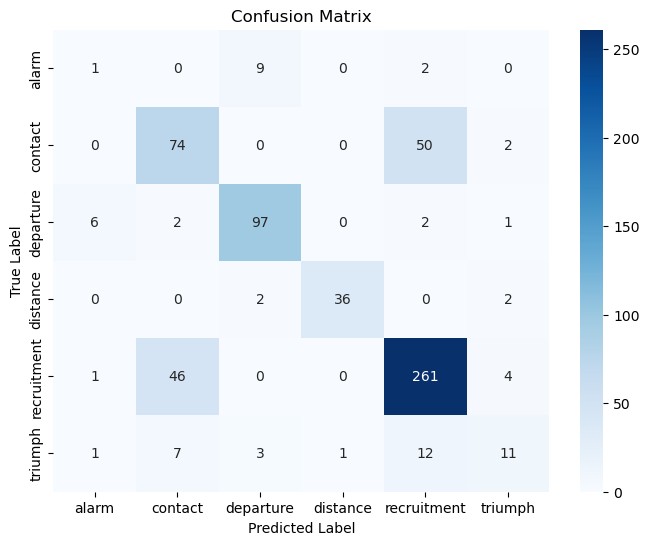

In [26]:
y_test_labels = le.inverse_transform(true_labels)
y_pred_labels = le.inverse_transform(predicted_labels)
print(classification_report(y_test_labels, y_pred_labels))
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Spectrograms

In [27]:
class SpecDataset(Dataset):
    def __init__(self, df):
        self.features = np.array(df['log_padded_spectrogram'].tolist(), dtype=np.float32)  # Shape: (n_samples, 16, 215)
        self.labels = np.array(df['encoded_call_type'], dtype=np.int64)  # Shape: (n_samples,)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        return torch.tensor(x), torch.tensor(y)

ds = SpecDataset(calls_df)

num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = round(num_items * 0.1)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 44, 170])
44 170


In [30]:
class SpecCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 44, 170)
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1), # (16, 44, 170)
            nn.MaxPool2d(kernel_size=(2, 2)), # (16, 22, 85)
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # (32, 22, 85)
            nn.Flatten(),
            nn.Linear(32 * 22 * 85, 128),
            nn.Linear(128, num_classes),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# Instantiate model
num_classes = 6
model = SpecCNN(num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
model.to(device)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dl):.4f}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/10, Loss: 2.8260
Epoch 2/10, Loss: 1.2574
Epoch 3/10, Loss: 1.1046
Epoch 4/10, Loss: 1.0553
Epoch 5/10, Loss: 1.0263
Epoch 6/10, Loss: 1.0135
Epoch 7/10, Loss: 0.9897
Epoch 8/10, Loss: 1.0040
Epoch 9/10, Loss: 0.9983
Epoch 10/10, Loss: 0.9571
Test Accuracy: 80.54%


In [31]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get the predicted class (index with max probability)
        _, predicted = torch.max(outputs, 1)
        
        # Append to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

              precision    recall  f1-score   support

       alarm       0.67      0.33      0.44         6
     contact       0.60      0.66      0.63       121
   departure       0.90      0.98      0.94       101
    distance       0.96      0.90      0.93        52
 recruitment       0.85      0.85      0.85       321
     triumph       0.60      0.28      0.38        32

    accuracy                           0.81       633
   macro avg       0.76      0.67      0.70       633
weighted avg       0.80      0.81      0.80       633



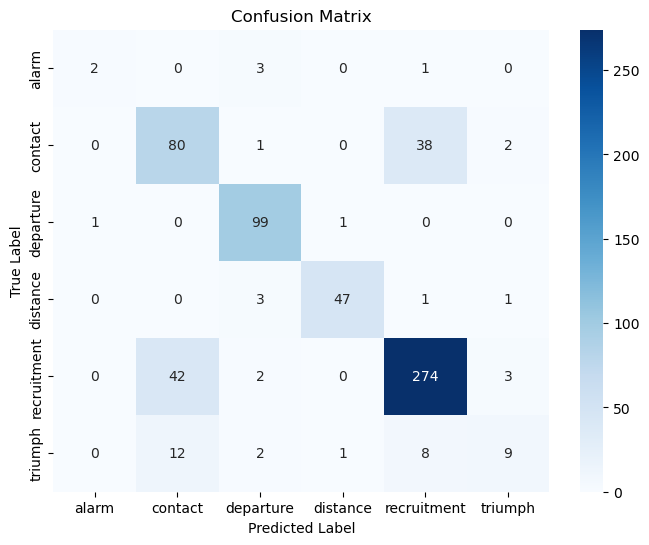

In [32]:
y_test_labels = le.inverse_transform(true_labels)
y_pred_labels = le.inverse_transform(predicted_labels)
print(classification_report(y_test_labels, y_pred_labels))
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()